## Load Dataset

In [1]:
import pyodbc
import mysql.connector
import dask.dataframe as dd
import pandas as pd
# from scripts.db_utils import create_ebay_connection
import os 
from dotenv import load_dotenv

load_dotenv()

def create_ebay_connection():
    """Create connection to the hosted SQL Server database for IP addresses."""
    try:
        connection = pyodbc.connect(
            f"DRIVER={{MySQL ODBC 9.1 Unicode Driver}};"
            f"SERVER={os.getenv('EBAY_DB_HOST')};"
            f"DATABASE={os.getenv('EBAY_DB_NAME')};"
            f"UID={os.getenv('EBAY_DB_USER')};"
            f"PWD={os.getenv('EBAY_DB_PASSWORD')}"
        )
        return connection
    except pyodbc.Error as e:
        print(f"Error connecting to hosted database: {e}")
        return None
# Database connection parameters
conn = create_ebay_connection()

query = "SELECT * FROM tbl_iptrace_user_activity where ams_trans_rsn_cd=0"


def fetch_data_in_chunks(conn, query, chunk_size=100000):
    """
    Fetch data from the database in chunks, then convert to Dask DataFrame.
    """
    offset = 0
    while True:
        # Modify the query to include pagination using LIMIT and OFFSET for chunks
        paginated_query = f"{query} LIMIT {chunk_size} OFFSET {offset}"
        
        # Fetch data in chunks using pandas (it handles column and row alignment internally)
        df_chunk = pd.read_sql_query(paginated_query, conn)
        
        if df_chunk.empty:
            break
        
        # Convert to Dask DataFrame
        dask_df = dd.from_pandas(df_chunk, npartitions=4)
        
        yield dask_df
        
        offset += chunk_size


dask_chunks = []

# Fetch chunks and store them in the list
for dask_df_chunk in fetch_data_in_chunks(conn, query, chunk_size=100000):
    dask_chunks.append(dask_df_chunk)

# Concatenate all chunks into a single Dask DataFrame
full_dask_df = dd.concat(dask_chunks)


# Show the result
print(full_dask_df.head())


C:\Users\ramegupta\AppData\Local\Temp\ipykernel_22208\3663271736.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_chunk = pd.read_sql_query(paginated_query, conn)
C:\Users\ramegupta\AppData\Local\Temp\ipykernel_22208\3663271736.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_chunk = pd.read_sql_query(paginated_query, conn)
C:\Users\ramegupta\AppData\Local\Temp\ipykernel_22208\3663271736.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_chunk = pd.read_sql_query(paginated_query, conn)
C:\Users\ramegupta\

   id     CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
0   1  77.111.247.168 2020-08-02 18:37:01   
1   2   66.249.73.101 2020-08-21 03:36:38   
2   3  77.111.247.129 2020-08-21 03:36:38   
3   4   66.249.73.101 2020-08-21 03:36:33   
4   5  77.111.247.129 2020-08-21 03:36:33   

                                          BRWSR_NAME  ams_trans_rsn_cd  \
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                 0   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                 0   
2  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                 0   
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                 0   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...                 0   

  ams_pblshr_id    buyer_id  is_vpn            click_id  
0    5574672411   valen_949       1  209245484389035777  
1    5574672411  morbanisaf       1  209453736892211586  
2    5574672411  morbanisaf       1  209453736892211586  
3    5574672411  morbanisaf       1  209453736892211

In [42]:
# full_dask_df = full_dask_df.drop(columns=['id', 'ams_trans_rsn_cd', 'is_vpn'])
full_dask_df.tail()


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id
54238,172.226.114.69,2024-09-05 11:04:49,ebayUserAgent/eBayIOS;6.174.0;iOS;17.6.1;Apple...,5575612316,srw38,226172465646404352
54239,208.115.224.233,2024-09-29 06:41:18,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5575532731,katzenklo_16,226442175813927936
54240,138.199.29.213,2024-10-09 03:15:37,ebayUserAgent/eBayAndroid;6.179.0;Android;14;s...,5575319207,guyver13,226553867601852672
54241,172.225.240.192,2024-10-27 03:30:27,Mozilla/5.0 (iPhone; CPU iPhone OS 18_1 like M...,5575376664,winde_-129,226757201610955392
54242,172.226.114.83,2024-11-03 04:57:09,Mozilla/5.0 (iPhone; CPU iPhone OS 18_0_1 like...,5575791307,monika_pl,226837779948133120


In [30]:
unique_count = full_dask_df['click_id'].nunique().compute()

# Display the result
print(f"Unique value count in 'click_id': {unique_count}")


Unique value count in 'click_id': 918884


In [31]:
print('no. of rows :', full_dask_df.shape[0].compute())

no. of rows : 1254243


## Prepare test(300k rows) and train(100k rows) data

In [43]:
import dask.dataframe as dd

# Convert the Dask DataFrame to Pandas DataFrame
full_df_pandas = full_dask_df.compute().reset_index(drop=True)

# Sample 300k rows for the training set using Pandas
train_df_pandas = full_df_pandas.sample(n=300000, random_state=42)

# Remove the sampled rows for training set from the original DataFrame to get the remaining rows
remaining_df_pandas = full_df_pandas[~full_df_pandas.index.isin(train_df_pandas.index)]

# Sample 100k rows for the testing set from the remaining rows
test_df_pandas = remaining_df_pandas.sample(n=100000, random_state=42)

# Check the sizes of the sampled DataFrames
train_size = train_df_pandas.shape[0]
test_size = test_df_pandas.shape[0]

print(f"Training set size: {train_size}")
print(f"Testing set size: {test_size}")





Training set size: 300000
Testing set size: 100000


In [45]:
train_df_pandas.to_csv('../data/csv/train_set.csv', index=False)
test_df_pandas.to_csv('../data/csv/test_set.csv', index=False)


## Load train dataset and implement preprocessing

In [1]:
import pandas as pd

df = pd.read_csv('../data/csv/train_set.csv')

In [2]:
df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id
0,77.234.43.168,2021-04-07 06:27:09,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,5574630565,beckside3,212048429032826368
1,185.54.228.40,2022-06-08 06:26:28,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,5575133559,marti7773,216884110377366784
2,3.10.22.118,2024-10-06 09:41:39,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5575714060,mick8692,226522931926925952
3,77.111.247.12,2021-09-05 22:52:03,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,smsworld,213755362152319232
4,144.76.31.247,2021-06-06 14:29:39,ebayUserAgent/eBayIOS;6.18.1;iOS;14.4.2;Apple;...,5575134381,a_e2634,212729827204423680


In [3]:
from user_agents import parse
import pandas as pd
import swifter  # for parallel processing with Pandas (install with `pip install swifter`)

# Dictionary to cache parsed user-agent strings and reduce redundant parsing
user_agent_cache = {}

def extract_user_agent_features_optimized(ua_string):
    # Check if this user-agent string has already been parsed
    if ua_string in user_agent_cache:
        return user_agent_cache[ua_string]
    
    # Parse the user agent string and store parsed results in a variable
    user_agent = parse(ua_string)
    
    # Extract required features
    result = {
        'browser': user_agent.browser.family,
        # 'browser_version': user_agent.browser.version_string,
        'os': user_agent.os.family,
        # 'os_version': user_agent.os.version_string,
        'device_type': (
    'mobile' if user_agent.is_mobile else
    'desktop' if user_agent.is_pc else
    'tablet' if user_agent.is_tablet else
    'bot' if user_agent.is_bot else 'other'
        )
    }
    
    # Store result in the cache
    user_agent_cache[ua_string] = result
    
    return result

# Apply optimized function to the user-agent column with parallel processing using swifter
df_user_agent_features = df['BRWSR_NAME'].swifter.apply(extract_user_agent_features_optimized).apply(pd.Series)
df = pd.concat([df, df_user_agent_features], axis=1)
df = df.drop('BRWSR_NAME', axis=1)
def categorize_browser(browser_column):
    # Define the browsers to keep based on the 10,000 row threshold
    popular_browsers = ['Chrome Mobile', 'Chrome', 'Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Firefox', 'Samsung Internet', 'Safari', 'Google', 'Chrome Mobile', 'Opera', 'FacebookBot', 'Facebook', 'ImagesiftBot']

    # Apply the categorization
    browser_column = browser_column.apply(lambda x: x if x in popular_browsers else 'Other')
    return browser_column

# Function to categorize OS based on the 1% rule and keeping till Ubuntu
def categorize_os(os_column):
    # Define the OSes to keep based on the row threshold (up to Ubuntu)
    popular_os = ['Android', 'Other', 'iOS', 'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Chrome OS']

    # Apply the categorization
    os_column = os_column.apply(lambda x: x if x in popular_os else 'Other')
    return os_column

# Apply categorization functions to the DataFrame
df['browser'] = categorize_browser(df['browser'])
df['os'] = categorize_os(df['os'])

# Display the transformed DataFrame
print(df)

c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pandas Apply: 100%|██████████| 300000/300000 [00:35<00:00, 8401.86it/s] 


           CLNT_RMT_IP   ROI_CLICK_EVENT_TS  ams_pblshr_id   buyer_id  \
0        77.234.43.168  2021-04-07 06:27:09     5574630565  beckside3   
1        185.54.228.40  2022-06-08 06:26:28     5575133559  marti7773   
2          3.10.22.118  2024-10-06 09:41:39     5575714060   mick8692   
3        77.111.247.12  2021-09-05 22:52:03     5574672411   smsworld   
4        144.76.31.247  2021-06-06 14:29:39     5575134381    a_e2634   
...                ...                  ...            ...        ...   
299995  89.238.183.236  2022-06-10 05:42:52     5575403800   keen1991   
299996     45.82.71.29  2022-01-07 00:35:27     5575082068   supenko2   
299997     5.62.43.249  2022-04-25 05:05:23     5575376664    breaba0   
299998  172.224.226.88  2024-07-23 00:01:16     5575612316  bri-95943   
299999     5.62.43.205  2021-05-07 14:17:45     5574672411  david3380   

                  click_id                     browser        os device_type  
0       212048429032826368                  

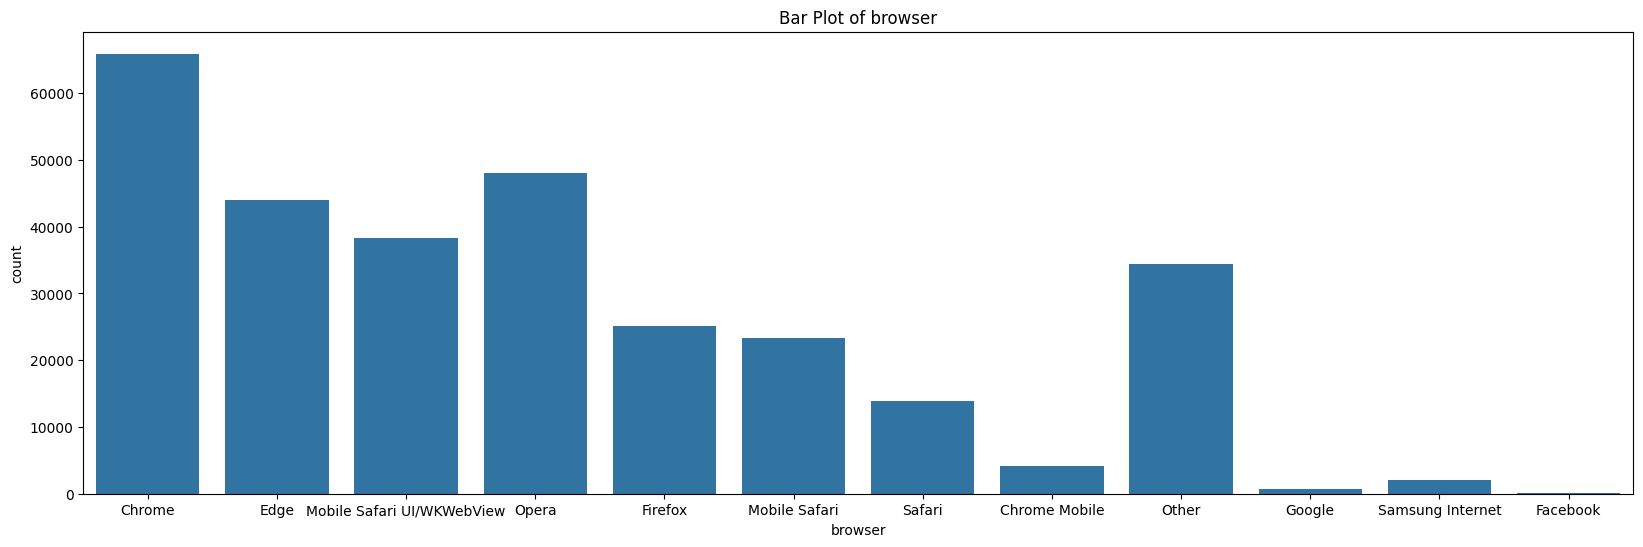

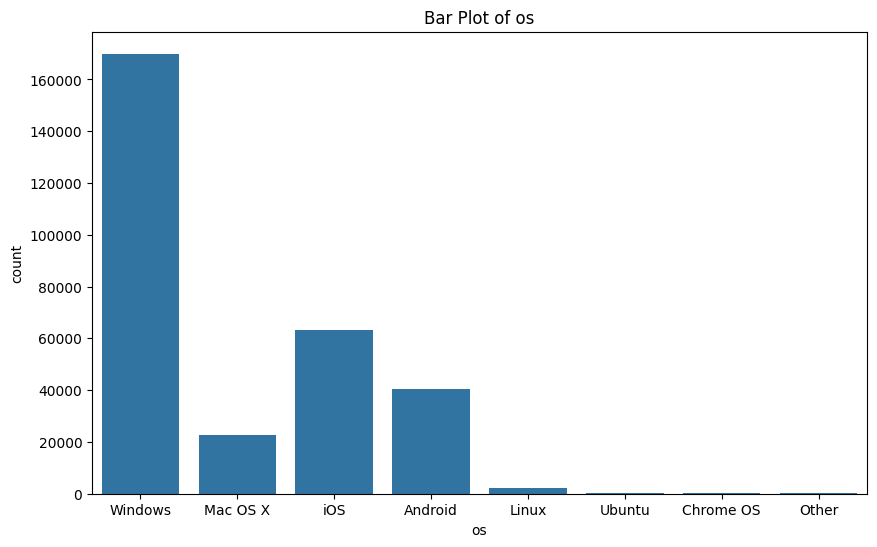

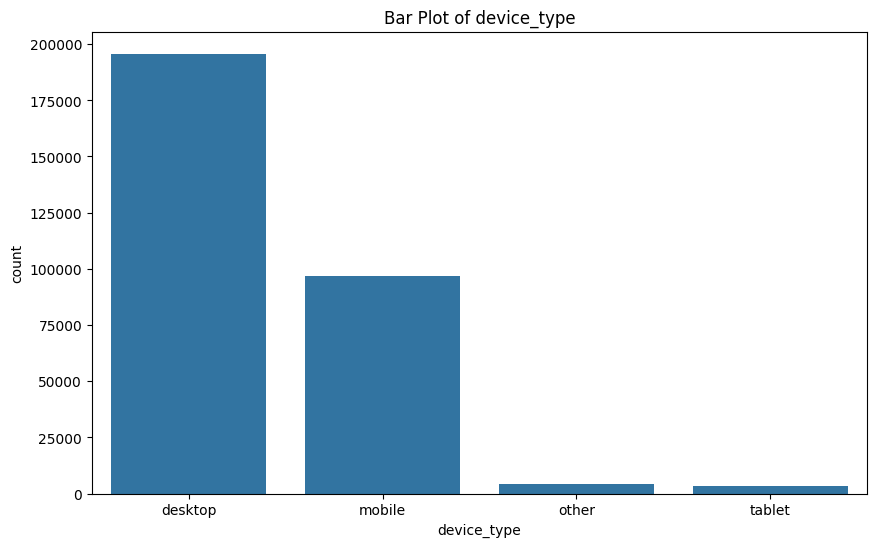

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 6))
sns.countplot(x='browser', data=df)
plt.title('Bar Plot of browser')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='os', data=df)
plt.title('Bar Plot of os')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='device_type', data=df)
plt.title('Bar Plot of device_type')
plt.show()



In [5]:
import re

# Function to check if the IP address is valid
def is_valid_ipv4(ip):
    if pd.isna(ip):  # Check for None or NaN
        return False
    pattern = r'^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'
    return re.match(pattern, ip) is not None

# Apply the function and create a mask for valid IP addresses
valid_ips_mask = df['CLNT_RMT_IP'].apply(is_valid_ipv4)

# Drop rows with invalid IP addresses
df = df[valid_ips_mask]

import socket
import struct
from sklearn.preprocessing import OneHotEncoder


# 1. Convert IP to integer
def ipv4_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

df['ip_as_int'] = df['CLNT_RMT_IP'].apply(ipv4_to_int)
df['ROI_CLICK_EVENT_TS'] = pd.to_datetime(df['ROI_CLICK_EVENT_TS'])


# 3. Extract features from datetime
df['year'] = df['ROI_CLICK_EVENT_TS'].dt.year
df['month'] = df['ROI_CLICK_EVENT_TS'].dt.month
df['day'] = df['ROI_CLICK_EVENT_TS'].dt.day
df['hour'] = df['ROI_CLICK_EVENT_TS'].dt.hour
df['minute'] = df['ROI_CLICK_EVENT_TS'].dt.minute
df['second'] = df['ROI_CLICK_EVENT_TS'].dt.second
df['day_of_week'] = df['ROI_CLICK_EVENT_TS'].dt.dayofweek  # Monday=0, Sunday=6

# 4. Drop original date and time columns
# df.drop(['CLNT_RMT_IP', 'CLICK_TS'], axis=1, inplace=True)


In [16]:
df.shape

(300000, 16)

In [17]:
df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,browser,os,device_type,ip_as_int,year,month,day,hour,minute,second,day_of_week
0,77.234.43.168,2021-04-07 06:27:09,5574630565,beckside3,212048429032826368,Chrome,Windows,desktop,1307192232,2021,4,7,6,27,9,2
1,185.54.228.40,2022-06-08 06:26:28,5575133559,marti7773,216884110377366784,Chrome,Mac OS X,desktop,3107382312,2022,6,8,6,26,28,2
2,3.10.22.118,2024-10-06 09:41:39,5575714060,mick8692,226522931926925952,Edge,Windows,desktop,50992758,2024,10,6,9,41,39,6
3,77.111.247.12,2021-09-05 22:52:03,5574672411,smsworld,213755362152319232,Edge,Windows,desktop,1299183372,2021,9,5,22,52,3,6
4,144.76.31.247,2021-06-06 14:29:39,5575134381,a_e2634,212729827204423680,Mobile Safari UI/WKWebView,iOS,mobile,2420908023,2021,6,6,14,29,39,6


In [8]:
# import numpy as np
# def generate_features(df):
#     # 1. Aggregation by different categorical combinations
    
#     # Clicks per Publisher-Buyer
#     clicks_per_publisher_buyer = df.groupby(['ams_pblshr_id', 'buyer_id']).agg(
#         clicks_per_publisher_buyer=('click_id', 'count'),
#         avg_click_time_per_publisher_buyer=('hour', 'mean'),
#         clicks_per_hour_per_publisher_buyer=('hour', 'count'),
#         unique_ip_addresses_per_publisher_buyer=('ip_as_int', 'nunique'),
#         days_since_last_click_per_publisher_buyer=('day', lambda x: x.max() - x.min())
#     ).reset_index()
#     clicks_per_publisher_buyer.columns = [f'publisher_buyer_{col}' for col in clicks_per_publisher_buyer.columns]
    
#     # Clicks per Buyer-Click ID
#     clicks_per_buyer_click_id = df.groupby(['buyer_id', 'click_id']).agg(
#         clicks_per_buyer_click_id=('click_id', 'count'),
#         avg_time_between_clicks_per_buyer_click_id=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_publishers_per_buyer_click_id=('ams_pblshr_id', 'nunique'),
#         clicks_per_device_type_per_buyer_click_id=('device_type', 'count')
#     ).reset_index()
#     clicks_per_buyer_click_id.columns = [f'buyer_click_id_{col}' for col in clicks_per_buyer_click_id.columns]
    
#     # Clicks per Publisher-Browser
#     clicks_per_publisher_browser = df.groupby(['ams_pblshr_id', 'browser']).agg(
#         clicks_per_publisher_browser=('click_id', 'count'),
#         avg_click_time_per_publisher_browser=('hour', 'mean'),
#         clicks_per_ip_per_publisher_browser=('ip_as_int', 'count'),
#         unique_buyers_per_publisher_browser=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_publisher_browser.columns = [f'publisher_browser_{col}' for col in clicks_per_publisher_browser.columns]
    
#     # Clicks per OS-Device Type
#     clicks_per_os_device_type = df.groupby(['os', 'device_type']).agg(
#         clicks_per_os_device_type=('click_id', 'count'),
#         clicks_per_hour_per_os_device_type=('hour', 'count'),
#         clicks_per_day_of_week_per_os_device_type=('day_of_week', 'count'),
#         unique_buyers_per_os_device_type=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_os_device_type.columns = [f'os_device_type_{col}' for col in clicks_per_os_device_type.columns]
    
#     # Clicks per Buyer-Device Type
#     clicks_per_buyer_device_type = df.groupby(['buyer_id', 'device_type']).agg(
#         clicks_per_buyer_device_type=('click_id', 'count'),
#         avg_click_time_per_buyer_device_type=('hour', 'mean'),
#         clicks_per_browser_per_buyer_device_type=('browser', 'count')
#     ).reset_index()
#     clicks_per_buyer_device_type.columns = [f'buyer_device_type_{col}' for col in clicks_per_buyer_device_type.columns]
    
#     # Clicks per IP-Browser
#     clicks_per_ip_browser = df.groupby(['ip_as_int', 'browser']).agg(
#         clicks_per_ip_browser=('click_id', 'count'),
#         avg_time_between_clicks_per_ip_browser=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_ip_browser=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_ip_browser.columns = [f'ip_browser_{col}' for col in clicks_per_ip_browser.columns]
    
#     # Clicks per IP-Device Type
#     clicks_per_ip_device_type = df.groupby(['ip_as_int', 'device_type']).agg(
#         clicks_per_ip_device_type=('click_id', 'count'),
#         clicks_per_device_type_per_ip=('device_type', 'count')
#     ).reset_index()
#     clicks_per_ip_device_type.columns = [f'ip_device_type_{col}' for col in clicks_per_ip_device_type.columns]
    
#     # Clicks per Browser-OS
#     clicks_per_browser_os = df.groupby(['browser', 'os']).agg(
#         clicks_per_browser_os=('click_id', 'count'),
#         avg_time_between_clicks_per_browser_os=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_browser_os=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_browser_os.columns = [f'browser_os_{col}' for col in clicks_per_browser_os.columns]
    
#     # Clicks per IP-Device Type-OS
#     clicks_per_ip_device_os = df.groupby(['ip_as_int', 'device_type', 'os']).agg(
#         clicks_per_ip_device_os=('click_id', 'count'),
#         avg_time_between_clicks_per_ip_device_os=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_ip_device_os=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_ip_device_os.columns = [f'ip_device_os_{col}' for col in clicks_per_ip_device_os.columns]
    
#     # Combine all features into a single DataFrame
#     features_df = pd.concat([
#         clicks_per_publisher_buyer,
#         clicks_per_buyer_click_id,
#         clicks_per_publisher_browser,
#         clicks_per_os_device_type,
#         clicks_per_buyer_device_type,
#         clicks_per_ip_browser,
#         clicks_per_ip_device_type,
#         clicks_per_browser_os,
#         clicks_per_ip_device_os
#     ], axis=1)

#     return features_df

# # Generate features
# feature_df = generate_features(df)

# # Display the resulting features
# print(feature_df.head())


c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\L

   publisher_buyer_ams_pblshr_id publisher_buyer_buyer_id  \
0                   5.574628e+09            cushmanyblatz   
1                   5.574628e+09                   hbming   
2                   5.574628e+09              jenricoshea   
3                   5.574628e+09         rvanbilliard0276   
4                   5.574628e+09                 sbradc55   

   publisher_buyer_clicks_per_publisher_buyer  \
0                                         3.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         3.0   

   publisher_buyer_avg_click_time_per_publisher_buyer  \
0                                          18.333333    
1                                          14.000000    
2                                          10.000000    
3                                           5.000000    
4                                           9.666667 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Step 1: Select only numeric columns (int and float)
numeric_columns = feature_df.select_dtypes(include=['int64', 'float64'])

# Step 2: Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
numeric_columns_imputed = imputer.fit_transform(numeric_columns)

# Step 3: Convert the imputed numeric data back to DataFrame and retain column names
numeric_columns_imputed = pd.DataFrame(numeric_columns_imputed, columns=numeric_columns.columns)

# Step 4: Standardize the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_columns_imputed)

# Step 5: Apply KMeans for clustering
kmeans = KMeans(n_clusters=2)  # Specify number of clusters
kmeans_labels = kmeans.fit_predict(scaled_features)
numeric_columns_imputed['fraud_cluster'] = kmeans_labels

# Step 6: Mark fraud (cluster outliers) based on the cluster label
numeric_columns_imputed['is_fraud'] = numeric_columns_imputed['fraud_cluster'].apply(lambda x: 1 if x == 1 else 0)

# Step 7: Combine the features dataframe with the original dataframe
# Ensure we're only combining with the rows that were imputed (those that match numeric_columns_imputed)
df_with_features = df.loc[numeric_columns_imputed.index]  # This ensures indices match
df_with_features = pd.concat([df_with_features, numeric_columns_imputed], axis=1)

# Step 8: Display the results
print(df_with_features.head())  # Display first few rows

# Step 9: Visualize the clustering result using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe for visualization
df_with_features['pca1'] = reduced_features[:, 0]
df_with_features['pca2'] = reduced_features[:, 1]

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_features, x='pca1', y='pca2', hue='fraud_cluster', palette='Set1', s=60, alpha=0.7)
plt.title('Click Clusters and Fraud (Outliers)')
plt.show()


In [24]:
import pandas as pd
from itertools import combinations



# Step 1: Generate all possible combinations of 'CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id'
columns = ['CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id']
combinations_list = []

# Add single column combinations
for i in range(1, len(columns) + 1):
    combinations_list.extend(combinations(columns, i))

# Step 2: Group by each combination and get the count of 'click_id'
result_list = []
for comb in combinations_list:
    grouped = df.groupby(list(comb)).size().reset_index(name=f'click_count_{"+".join(comb)}')
    result_list.append(grouped)
print(len(result_list))

# Step 3: Merge all grouped results back into the original dataframe
merged_df = df.copy()
for result in result_list:
    merged_df = pd.merge(merged_df, result, how='left', on=list(result.columns[:-1]))  # Exclude 'click_count'

# Step 4: Handle missing values (if any) and fill them with 0 or another appropriate value
merged_df.fillna(0, inplace=True)

click_count_columns = [col for col in merged_df.columns if col.startswith('click_count')]

# Step 6: Apply scaling to the 'click_count' columns
scaler = StandardScaler()
merged_df[click_count_columns] = scaler.fit_transform(merged_df[click_count_columns])

# Output the final DataFrame with scaled features
print("DataFrame with Scaled Click Count Features:")
print(merged_df)


7
DataFrame with Scaled Click Count Features:
           CLNT_RMT_IP  ROI_CLICK_EVENT_TS  ams_pblshr_id   buyer_id  \
0        77.234.43.168 2021-04-07 06:27:09     5574630565  beckside3   
1        185.54.228.40 2022-06-08 06:26:28     5575133559  marti7773   
2          3.10.22.118 2024-10-06 09:41:39     5575714060   mick8692   
3        77.111.247.12 2021-09-05 22:52:03     5574672411   smsworld   
4        144.76.31.247 2021-06-06 14:29:39     5575134381    a_e2634   
...                ...                 ...            ...        ...   
299995  89.238.183.236 2022-06-10 05:42:52     5575403800   keen1991   
299996     45.82.71.29 2022-01-07 00:35:27     5575082068   supenko2   
299997     5.62.43.249 2022-04-25 05:05:23     5575376664    breaba0   
299998  172.224.226.88 2024-07-23 00:01:16     5575612316  bri-95943   
299999     5.62.43.205 2021-05-07 14:17:45     5574672411  david3380   

                  click_id                     browser        os device_type  \
0       2

In [25]:
merged_df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,browser,os,device_type,ip_as_int,year,...,minute,second,day_of_week,click_count_CLNT_RMT_IP,click_count_ams_pblshr_id,click_count_buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id,click_count_CLNT_RMT_IP+buyer_id,click_count_ams_pblshr_id+buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id
0,77.234.43.168,2021-04-07 06:27:09,5574630565,beckside3,212048429032826368,Chrome,Windows,desktop,1307192232,2021,...,27,9,2,-0.236103,0.054260,-0.217502,-0.244205,-0.197853,-0.202723,-0.186043
1,185.54.228.40,2022-06-08 06:26:28,5575133559,marti7773,216884110377366784,Chrome,Mac OS X,desktop,3107382312,2022,...,26,28,2,-0.373260,-0.134587,-0.202864,-0.241890,-0.193984,-0.187081,-0.181900
2,3.10.22.118,2024-10-06 09:41:39,5575714060,mick8692,226522931926925952,Edge,Windows,desktop,50992758,2024,...,41,39,6,-0.203186,-0.488891,-0.177246,-0.248835,-0.197853,-0.190991,-0.186043
3,77.111.247.12,2021-09-05 22:52:03,5574672411,smsworld,213755362152319232,Edge,Windows,desktop,1299183372,2021,...,52,3,6,0.323496,2.087291,-0.133330,0.414379,-0.178506,-0.112777,-0.165326
4,144.76.31.247,2021-06-06 14:29:39,5575134381,a_e2634,212729827204423680,Mobile Safari UI/WKWebView,iOS,mobile,2420908023,2021,...,29,39,6,-0.362287,-0.943882,-0.217502,-0.271983,-0.197853,-0.202723,-0.186043


In [26]:
categorical_features = ['browser', 'os', 'device_type']
df_encoded = pd.get_dummies(merged_df, columns=categorical_features)
df_encoded.head()


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,ip_as_int,year,month,day,hour,...,os_Linux,os_Mac OS X,os_Other,os_Ubuntu,os_Windows,os_iOS,device_type_desktop,device_type_mobile,device_type_other,device_type_tablet
0,77.234.43.168,2021-04-07 06:27:09,5574630565,beckside3,212048429032826368,1307192232,2021,4,7,6,...,False,False,False,False,True,False,True,False,False,False
1,185.54.228.40,2022-06-08 06:26:28,5575133559,marti7773,216884110377366784,3107382312,2022,6,8,6,...,False,True,False,False,False,False,True,False,False,False
2,3.10.22.118,2024-10-06 09:41:39,5575714060,mick8692,226522931926925952,50992758,2024,10,6,9,...,False,False,False,False,True,False,True,False,False,False
3,77.111.247.12,2021-09-05 22:52:03,5574672411,smsworld,213755362152319232,1299183372,2021,9,5,22,...,False,False,False,False,True,False,True,False,False,False
4,144.76.31.247,2021-06-06 14:29:39,5575134381,a_e2634,212729827204423680,2420908023,2021,6,6,14,...,False,False,False,False,False,True,False,True,False,False


In [27]:
df_encoded.columns

Index(['CLNT_RMT_IP', 'ROI_CLICK_EVENT_TS', 'ams_pblshr_id', 'buyer_id',
       'click_id', 'ip_as_int', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'day_of_week', 'click_count_CLNT_RMT_IP',
       'click_count_ams_pblshr_id', 'click_count_buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id', 'browser_Chrome',
       'browser_Chrome Mobile', 'browser_Edge', 'browser_Facebook',
       'browser_Firefox', 'browser_Google', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', 'device_type_desktop', 'device_type_mobile',
       'device_type_other', 'device_type_tablet'],
      dtype='object')

     CLNT_RMT_IP  ROI_CLICK_EVENT_TS  ams_pblshr_id   buyer_id  \
0  77.234.43.168 2021-04-07 06:27:09     5574630565  beckside3   
1  185.54.228.40 2022-06-08 06:26:28     5575133559  marti7773   
2    3.10.22.118 2024-10-06 09:41:39     5575714060   mick8692   
3  77.111.247.12 2021-09-05 22:52:03     5574672411   smsworld   
4  144.76.31.247 2021-06-06 14:29:39     5575134381    a_e2634   

             click_id                     browser        os device_type  \
0  212048429032826368                      Chrome   Windows     desktop   
1  216884110377366784                      Chrome  Mac OS X     desktop   
2  226522931926925952                        Edge   Windows     desktop   
3  213755362152319232                        Edge   Windows     desktop   
4  212729827204423680  Mobile Safari UI/WKWebView       iOS      mobile   

    ip_as_int  year  ...     ip_as_int  click_count_CLNT_RMT_IP  \
0  1307192232  2021  ...  1.307192e+09                -0.236103   
1  3107382312  202

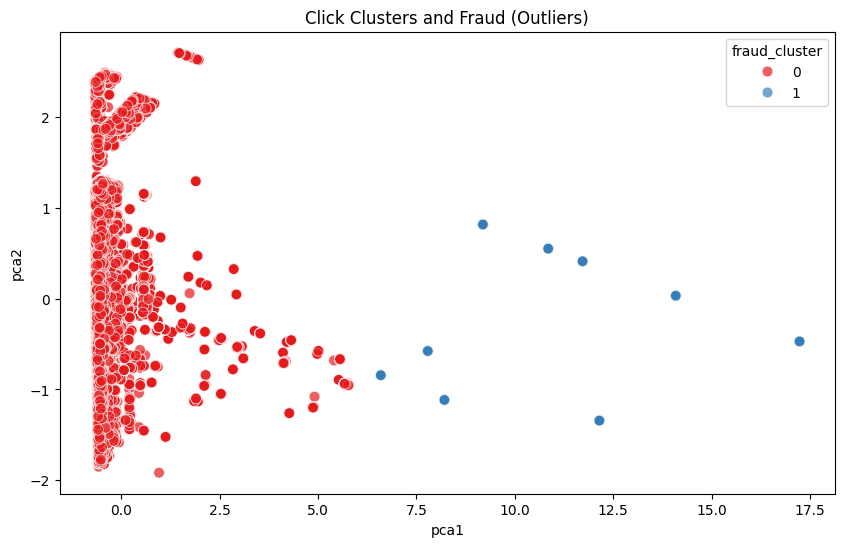

In [35]:
cols = ['ip_as_int', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'day_of_week', 'click_count_CLNT_RMT_IP',
       'click_count_ams_pblshr_id', 'click_count_buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id', 'browser_Chrome',
       'browser_Chrome Mobile', 'browser_Edge', 'browser_Facebook',
       'browser_Firefox', 'browser_Google', 'browser_Mobile Safari',
       'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
       'browser_Safari', 'browser_Samsung Internet', 'os_Android',
       'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
       'os_Windows', 'os_iOS', ]
feature_df = df_encoded[cols]

# 'device_type_desktop', 'device_type_mobile',
#        'device_type_other', 'device_type_tablet'

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Step 1: Select only numeric columns (int and float)
numeric_columns = feature_df.select_dtypes(include=['int64', 'float64'])

# Step 2: Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
numeric_columns_imputed = imputer.fit_transform(numeric_columns)

# Step 3: Convert the imputed numeric data back to DataFrame and retain column names
numeric_columns_imputed = pd.DataFrame(numeric_columns_imputed, columns=numeric_columns.columns)

# Step 4: Standardize the numeric features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(numeric_columns_imputed)

# Step 5: Apply KMeans for clustering
kmeans = KMeans(n_clusters=2)  # Specify number of clusters
kmeans_labels = kmeans.fit_predict(scaled_features)
numeric_columns_imputed['fraud_cluster'] = kmeans_labels

# Step 6: Mark fraud (cluster outliers) based on the cluster label
numeric_columns_imputed['is_fraud'] = numeric_columns_imputed['fraud_cluster'].apply(lambda x: 1 if x == 1 else 0)

# Step 7: Combine the features dataframe with the original dataframe
# Ensure we're only combining with the rows that were imputed (those that match numeric_columns_imputed)
df_with_features = df.loc[numeric_columns_imputed.index]  # This ensures indices match
df_with_features = pd.concat([df_with_features, numeric_columns_imputed], axis=1)

# Step 8: Display the results
print(df_with_features.head())  # Display first few rows

# Step 9: Visualize the clustering result using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe for visualization
df_with_features['pca1'] = reduced_features[:, 0]
df_with_features['pca2'] = reduced_features[:, 1]

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_features, x='pca1', y='pca2', hue='fraud_cluster', palette='Set1', s=60, alpha=0.7)
plt.title('Click Clusters and Fraud (Outliers)')
plt.show()


In [36]:
# df_with_features.to_csv('../data/csv/click_fraud_results.csv', index=False)
df_with_features.to_csv('../data/csv/click_fraud_results_2.csv', index=False)



In [34]:
selected_columns = ['CLNT_RMT_IP',  'ROI_CLICK_EVENT_TS', 'ams_pblshr_id', 'buyer_id',  
                    'fraud_cluster', 'is_fraud']

# Create a new DataFrame with only the selected columns
selected_df = df_with_features[selected_columns]

# Export this DataFrame to a CSV file
selected_df.to_csv('../data/csv/click_fraud_results.csv', index=False)
